In this section, calcium fluxes in a compartmentalized cell were modelled. Calcium can be present in the cytosol ($Ca_{cyt}$), bound to calcium binding proteins residing in the cytosol ($CaPr$), the Endoplasmic Reticulum (ER) ($Ca_{ER}$) as well as the mitochondria ($Ca_m$). 
The total calcium concentration ($Ca_{tot}$) can therefore be defined as:

$Ca_{tot} = Ca_{cyt} + \frac{\rho_{ER}}{\beta_{ER}}+Ca_{ER}+\frac{\rho_{m}}{\beta_{m}}+Ca_{m}+CaPr$

The total amount of the calcium binding protein ($Pr_{tot}$) in it's bound ($CaPr$) or unbound ($Pr$) form is defined as:

$Pr_{tot} = Pr + CaPr$

To desribe the rate of change of calcium conatnrations in the different compartments the following formulas can be used:

$\frac{dCa_{cyt}}{dt} = J_{ch} + J_{leak} - J_{pump} + J_{out} - J_{in} + k_- CaPr - k_+ Ca_{cyt}Pr$

In [2]:
#Import statements

# Basic Imports
from __future__ import division
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import math
import random
import copy
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML
import sympy.solvers.ode
from sympy import *

# Define the flux equations

def fluxPump(k_pump,Ca_cyt):
    return k_pump*Ca_cyt

def fluxCh(k_ch, Ca_cyt,Ca_ER,K1):
    return k_ch*((Ca_cyt**2)/(K1**2 + Ca_cyt**2))*(Ca_ER - Ca_cyt)

def fluxLeak(k_leak, Ca_ER, Ca_cyt):
    return k_leak*(Ca_ER - Ca_cyt)

def fluxIn(k_in, K2, Ca_cyt):
    return k_in*(Ca_cyt**8/(K2**8 + Ca_cyt**8))

def fluxOut(k_out, K3, Ca_cyt, km, Ca_m):
    return Ca_m*(k_out*(Ca_cyt**2 / (K3**2 + Ca_cyt**2))+km)

def calcCaPr(Ca_tot, Ca_cyt, Ca_ER, Ca_m, p_ER, p_m, b_ER, b_m):
    return Ca_tot - (Ca_ER*(p_ER/b_ER)) - (Ca_m*(p_m/b_m)) - Ca_cyt

def calcPr(Pr_tot, CaPr):
    return Pr_tot - CaPr

# Differential equations

def dCa_cyt(J_ch, J_leak, J_pump, J_in, J_out, k_minus, CaPr, k_plus, Ca_cyt, Pr):
    return J_ch + J_leak - J_pump + J_out - J_in + (k_minus*CaPr) - (k_plus*Ca_cyt*Pr)

def dCa_ER(beta_ER, rho_ER, J_pump, J_ch, J_leak):
    return (beta_ER/rho_ER)*(J_pump - J_ch - J_leak)

def dCa_m(beat_m, rho_m, J_in, J_out):
    return (beta_m/rho_m)*(J_in-J_out)    

# System of Ordinary Differential Equation

def ODE_Calcium_Sys(y0, t, Ca_tot, Pr_tot, p_ER, p_m, b_ER, b_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3):
    '''This function defines the system of ODES which controls the levels of calcium in the system'''
    
    # Separate initial conditions
    Ca_cyt, Ca_ER, Ca_m = y0
    
    # calculate dependent variables
    CaPr = calcCaPr(Ca_tot, Ca_cyt, Ca_ER, Ca_m, p_ER, p_m, b_ER, b_m)
    Pr = calcPr(Pr_tot, CaPr)
    J_pump = fluxPump(k_pump, Ca_cyt)
    J_ch = fluxCh(k_ch,Ca_cyt,Ca_ER,K1)
    J_leak = fluxLeak(k_leak, Ca_ER, Ca_cyt)
    J_in = fluxIn(k_in, K2, Ca_cyt)
    J_out = fluxOut(k_out, K3, Ca_cyt, k_m, Ca_m)
    
    Ca_cyt_1 = dCa_cyt(J_ch, J_leak, J_pump, J_in, J_out, k_minus, CaPr, k_plus, Ca_cyt, Pr)
    Ca_ER_1 = dCa_ER(beta_ER, rho_ER, J_pump, J_ch, J_leak)
    Ca_m_1 = dCa_m(beta_m, rho_m, J_in, J_out)
    
    return Ca_cyt_1, Ca_ER_1, Ca_m_1

In [3]:
# Declare parameters
#---------------------------------------
#Total concentrations (micro Moles)
Ca_tot =  90 
Pr_tot = 120

# Geometric Parameters

rho_ER = 0.01
rho_m = 0.01
beta_ER = 0.0025
beta_m = 0.0025

#Kinetics parameters

k_ch = 4100 #s^-1
k_pump = 20 #s^-1
k_leak = 0.01 #s^-1
k_in = 300 #(micro Moles s^-1)
k_out = 125 #s^-1
k_m = 0.00625 #s^-1
k_plus = 0.1 #(micro Moles)
k_minus = 0.01 #s^-1
K1 = 5 #(micro Moles)
K2 = 0.8 #(micro Moles)
K3 = 5 #(micro Moles)

#Initial concentrations (micro Moles)

Ca_cyt_0 = 0.3 
Ca_ER_0 = 0.2
Ca_m_0 = 1

#Run the system

time_steps = np.arange(0,300,0.01)

start = int(100/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

In [4]:
#print(calcium_over_time.T)

<IPython.core.display.Javascript object>


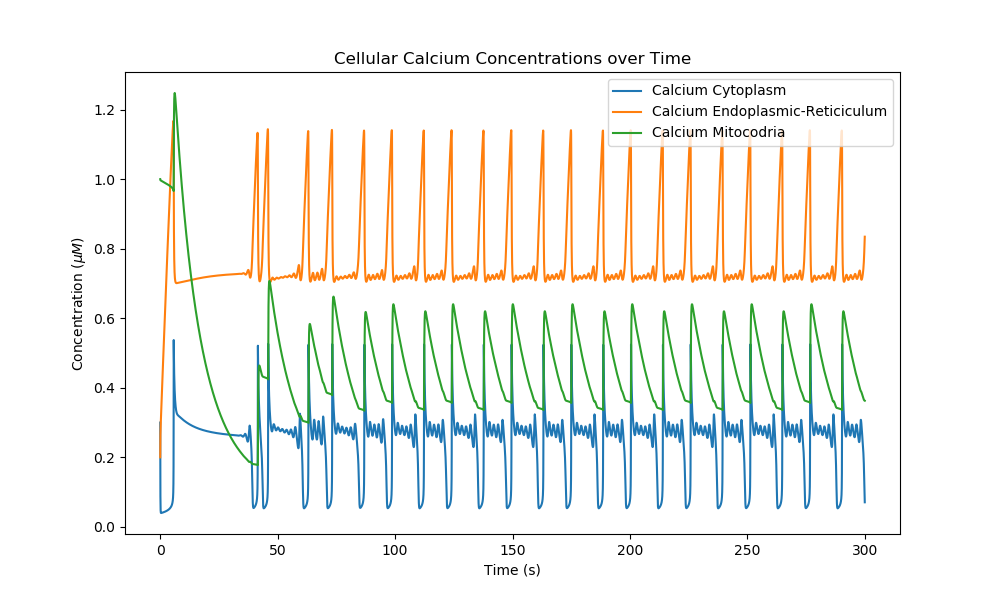

In [5]:
plt.figure(0,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()

<IPython.core.display.Javascript object>


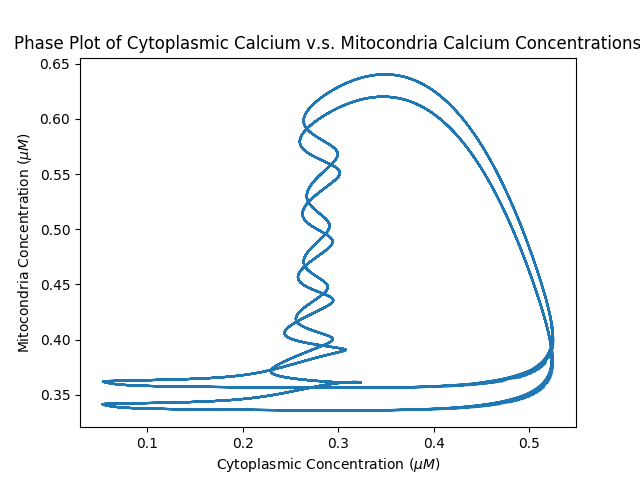

In [89]:
plt.figure(1)
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])

<IPython.core.display.Javascript object>


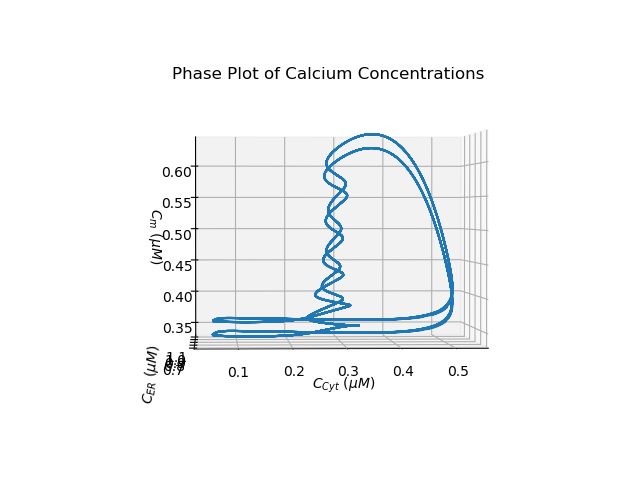

Text(0.5,0.92,'Phase Plot of Calcium Concentrations')

In [6]:
fig = plt.figure(2)
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')


<IPython.core.display.Javascript object>


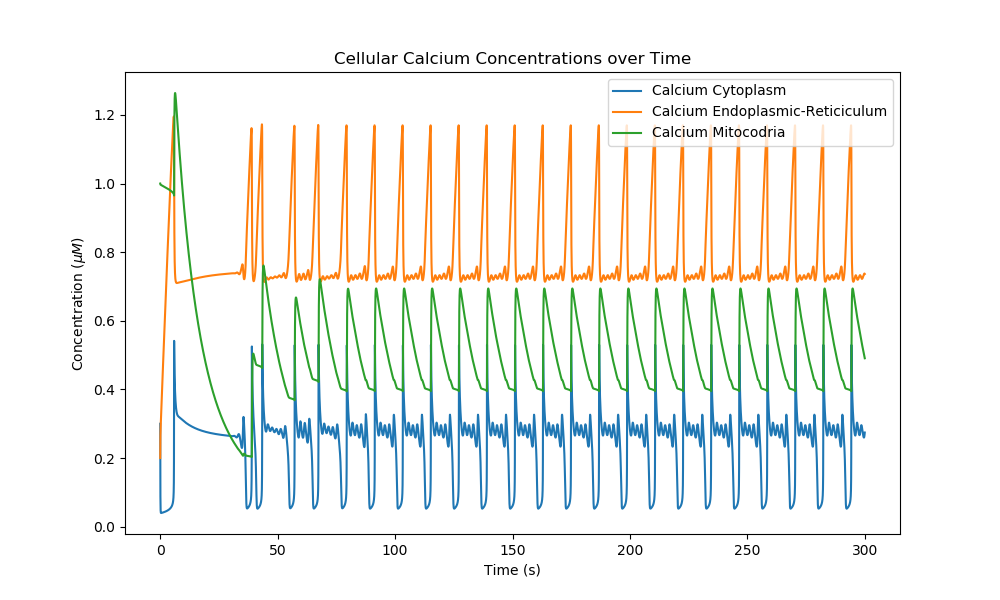

<IPython.core.display.Javascript object>


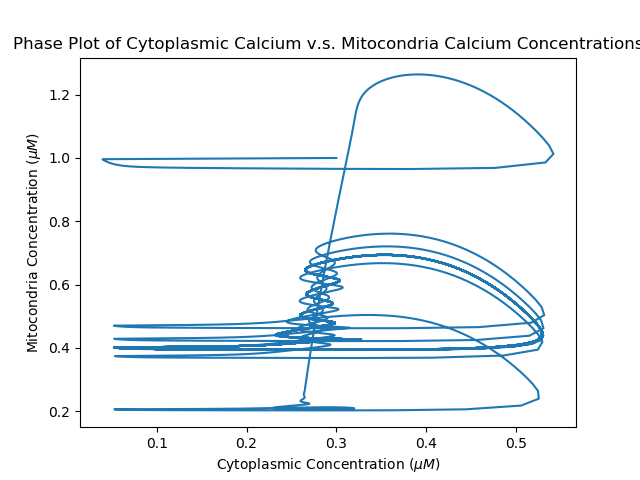

<IPython.core.display.Javascript object>


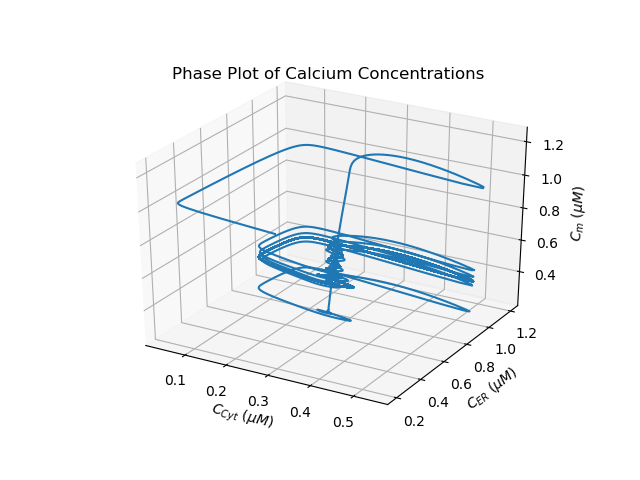

In [7]:
k_ch = 4000
start = int(0/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

plt.figure(3,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()
plt.show()

plt.figure(4)
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])
plt.show()

fig = plt.figure(5)
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')
plt.show()

In [1]:
k_ch = 2950
start = int(0/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

plt.figure(6,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()
plt.show()

plt.figure(7)
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])
plt.show()

fig = plt.figure(8)
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')
plt.show()

NameError: name 'odeint' is not defined